In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.2 MB/s eta 0:00:00


In [4]:
import dtaidistance
def get_DTW_dist(tcf,tcf_ref,n_res):
    # cdf1 and cdf2 should be evaluated at
    # similar time points

    distance = np.zeros(n_res)
    for i in range(n_res):
        m = np.gradient(tcf_ref[i,:])
        if np.where(m >= 0)[0].shape[0] == 0:
            cut = tcf_ref[:,0].shape[0]
        else:
            cut = np.where(m >= 0)[0][0]
        distance[i] = dtaidistance.dtw.distance(tcf_ref[i,:cut:5],tcf[:cut:5,i])

    return distance



In [5]:
data_prefix='/content/drive/MyDrive/AF2_dynamics/calculated_data/'
sys_names=['3ttp', '2pc0', '1q9p', '1ebw','4z4x','6p9a']

with open(f'{data_prefix}all_results.pkl','rb') as f:
    HA_tcf_calc=pickle.load(f)

In [6]:
tmp = HA_tcf_calc[0] | HA_tcf_calc[1]
HA_tcf_calc = tmp


In [7]:
HA_tcf_calc['3ttp']['AF2']['msas'] = [8, 16, 32, 64, 128, 256, 512]
HA_tcf_calc['2pc0']['AF2']['msas'] = [8, 16, 32, 64, 128, 256, 512]
HA_tcf_calc['1q9p']['AF2']['msas'] = [8, 16, 32, 64, 128, 256, 512]

In [8]:
HA_tcf_calc.keys(),HA_tcf_calc[sys_names[0]].keys(),HA_tcf_calc[sys_names[0]]['AF2'].keys(),HA_tcf_calc[sys_names[0]]['BioEMU'].keys()

(dict_keys(['1ebw', '4z4x', '6p9a', '3ttp', '2pc0', '1q9p']),
 dict_keys(['AF2', 'test', 'AFc', 'DiG', 'BioEMU', 'MD']),
 dict_keys(['non_scaled', 'scaled', 'CinvH', 'C', 'msas', 'n_samples', 't_axis']),
 dict_keys(['non_scaled', 'scaled', 'CinvH', 'C', 'msas', 'n_samples', 't_axis']))

# Only rMSA AF2

In [9]:
DTW_distances={}
sys_names=['3ttp', '2pc0', '1q9p', '1ebw','4z4x','6p9a']
nres_list = [99,99,95,99,99,99]
barrier_type='scaled'
timescales=['1000ns','100ns','10ns']
for ii,SYS in enumerate(sys_names):
    DTW_distances[SYS]={}
    # trj=md.load(f'/data/aranganathana2/AF2/Dynamics/topol_{SYS}.pdb')
    tcf_list = HA_tcf_calc[SYS]['AF2'][barrier_type]['tcf']
    print('========================================')

    for jj, timescale in enumerate(timescales):
        DTW_distances[SYS][timescale]={}
        DTW_distances[SYS][timescale]['dists']={}
        tcf_ref = HA_tcf_calc[SYS]['test'][timescale]['tcf'].T[1:]

        for mm,msa in enumerate(HA_tcf_calc[SYS]['AF2']['msas']):

            DTW_distances[SYS][timescale]['dists'][msa] = get_DTW_dist(tcf=tcf_list[mm],
                                                            tcf_ref=tcf_ref,
                                                            n_res=nres_list[ii])
            print(f"Processed SYS:{SYS}, MSA:{msa}, TIMESCALE:{timescale}")


Processed SYS:3ttp, MSA:8, TIMESCALE:1000ns
Processed SYS:3ttp, MSA:16, TIMESCALE:1000ns
Processed SYS:3ttp, MSA:32, TIMESCALE:1000ns
Processed SYS:3ttp, MSA:64, TIMESCALE:1000ns
Processed SYS:3ttp, MSA:128, TIMESCALE:1000ns
Processed SYS:3ttp, MSA:256, TIMESCALE:1000ns
Processed SYS:3ttp, MSA:512, TIMESCALE:1000ns
Processed SYS:3ttp, MSA:8, TIMESCALE:100ns
Processed SYS:3ttp, MSA:16, TIMESCALE:100ns
Processed SYS:3ttp, MSA:32, TIMESCALE:100ns
Processed SYS:3ttp, MSA:64, TIMESCALE:100ns
Processed SYS:3ttp, MSA:128, TIMESCALE:100ns
Processed SYS:3ttp, MSA:256, TIMESCALE:100ns
Processed SYS:3ttp, MSA:512, TIMESCALE:100ns
Processed SYS:3ttp, MSA:8, TIMESCALE:10ns
Processed SYS:3ttp, MSA:16, TIMESCALE:10ns
Processed SYS:3ttp, MSA:32, TIMESCALE:10ns
Processed SYS:3ttp, MSA:64, TIMESCALE:10ns
Processed SYS:3ttp, MSA:128, TIMESCALE:10ns
Processed SYS:3ttp, MSA:256, TIMESCALE:10ns
Processed SYS:3ttp, MSA:512, TIMESCALE:10ns
Processed SYS:2pc0, MSA:8, TIMESCALE:1000ns
Processed SYS:2pc0, MSA:16

=========================== 3ttp ===========================


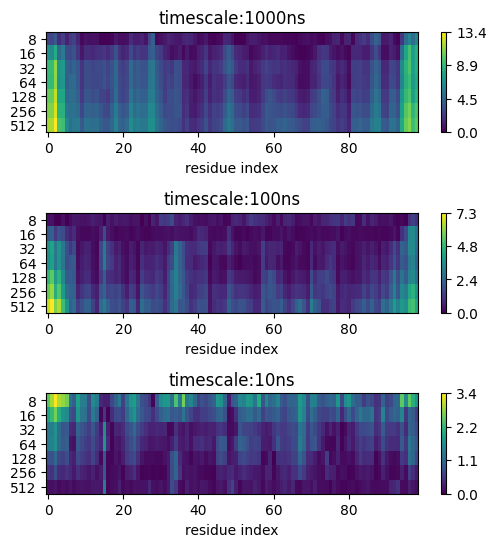

=========================== 2pc0 ===========================


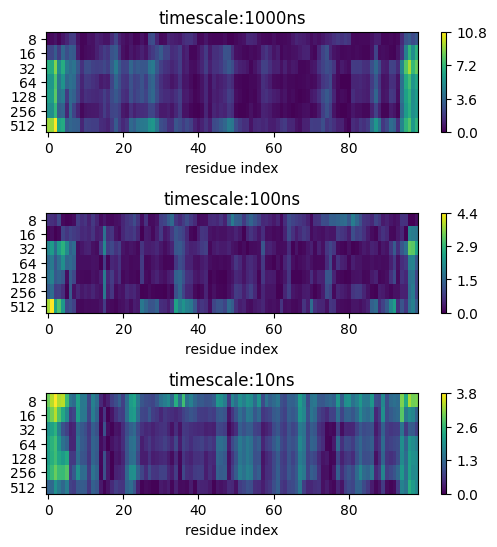

=========================== 1q9p ===========================


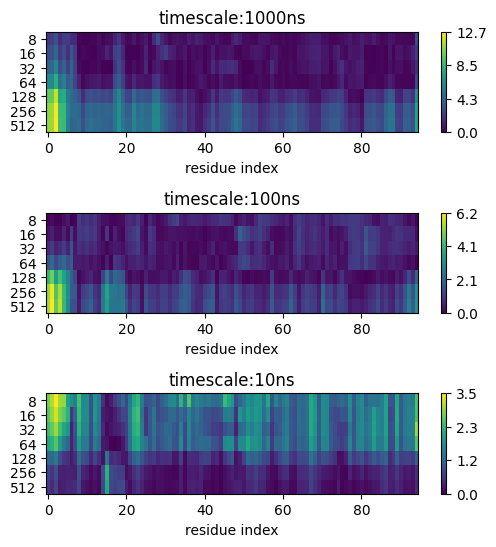

=========================== 1ebw ===========================


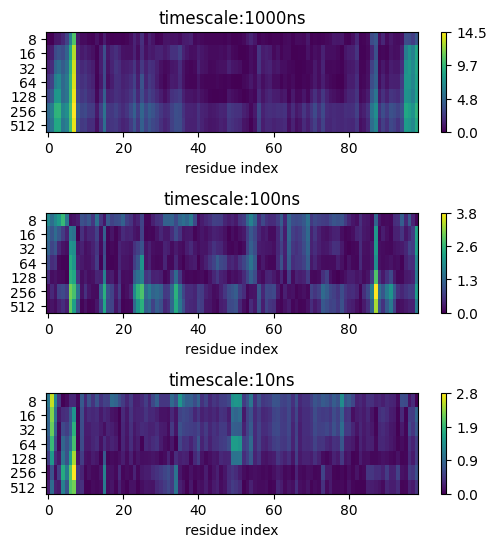

=========================== 4z4x ===========================


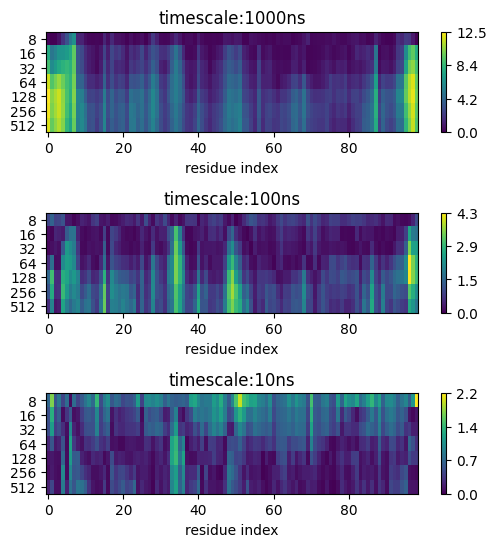

=========================== 6p9a ===========================


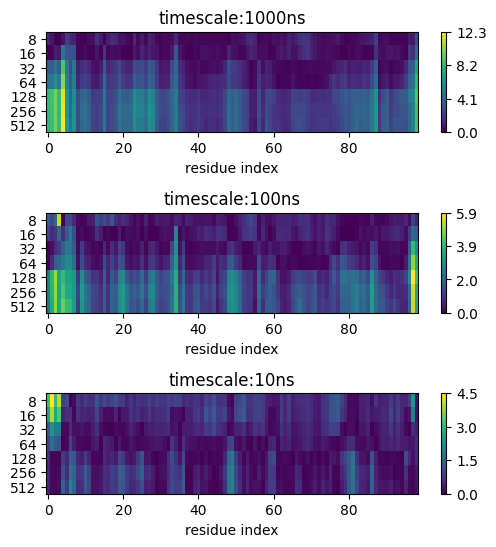

In [10]:

for ii,SYS in enumerate(sys_names):

    print(f'=========================== {SYS} ===========================')

    fig = plt.figure(figsize = (6, 6))
    for jj, timescale in enumerate(timescales):
        dummy=[]

        for kk, msa in enumerate(DTW_distances[SYS][timescale]['dists'].keys()):
            dummy.append(DTW_distances[SYS][timescale]['dists'][msa])

        dummy=np.array(dummy)

        msa_counts=np.zeros(len(DTW_distances[SYS][timescale]['dists'].keys()))
        for rr in range(dummy.shape[1]):
            ind_min=np.where(dummy[:,rr]==dummy[:,rr].min())[0]
            msa_counts[ind_min]+=1
        msa_counts=msa_counts*100/dummy.shape[1]
        DTW_distances[SYS][timescale]['explained'] = {}
        for kk, msa in enumerate(DTW_distances[SYS][timescale]['dists'].keys()):
            DTW_distances[SYS][timescale]['explained'][msa]=msa_counts[kk]

        plt.subplot(len(timescales),1,jj+1)
        plt.imshow(dummy, aspect = 'auto')
        ticks=np.linspace(dummy.min(),dummy.max(),4)
        cb=plt.colorbar(ticks=ticks)
        plt.yticks(ticks = np.arange(len(DTW_distances[SYS][timescale]['dists'].keys())), labels = [str(m) for m in DTW_distances[SYS][timescale]['dists'].keys()])
        plt.xlabel('residue index')
        plt.title(f'timescale:{timescale}')
        cb.set_ticks(ticks=ticks,labels=[str(np.round(ti,1)) for ti in ticks])
#         cb.set_ticklabels(ticks,[str(np.round(ti,1)) for ti in ticks])
    plt.subplots_adjust(hspace=0.8)
    plt.show()
    plt.close()


=========================== 3ttp ===========================


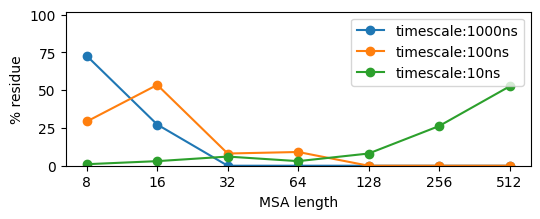

=========================== 2pc0 ===========================


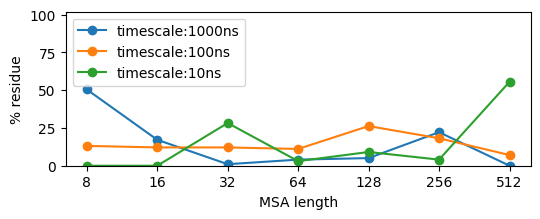

=========================== 1q9p ===========================


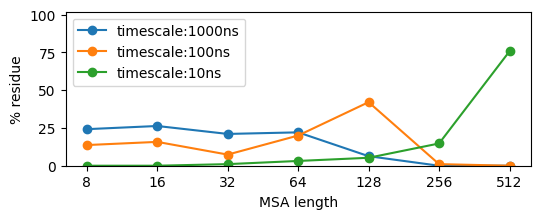

=========================== 1ebw ===========================


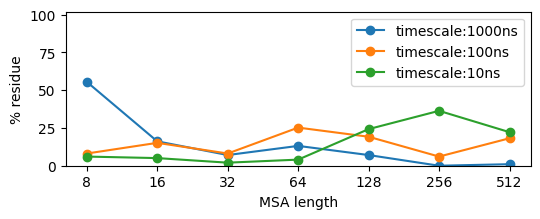

=========================== 4z4x ===========================


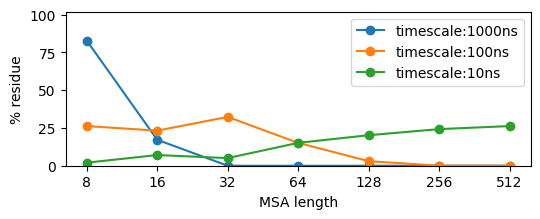

=========================== 6p9a ===========================


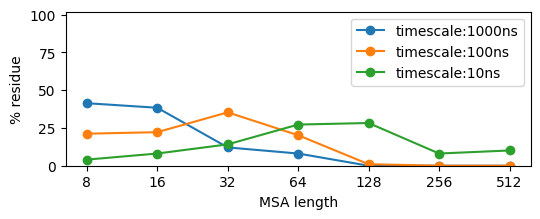

In [11]:
for ii,SYS in enumerate(sys_names):

    print(f'=========================== {SYS} ===========================')

    fig = plt.figure(figsize = (6, 2))
    for jj, timescale in enumerate(timescales):
        dummy=[]

        for kk, msa in enumerate(DTW_distances[SYS][timescale]['explained'].keys()):
            dummy.append(DTW_distances[SYS][timescale]['explained'][msa])

        dummy=np.array(dummy)

        plt.plot(dummy, '-o',label=f'timescale:{timescale}')
        plt.xticks(ticks = np.arange(len(DTW_distances[SYS][timescale]['explained'].keys())), labels = [str(m) for m in DTW_distances[SYS][timescale]['explained'].keys()])
    plt.legend()
    plt.xlabel('MSA length')
    plt.ylim([0,102])
    plt.ylabel('% residue');
    plt.show()
    plt.close()

In [12]:
import copy
DTW_distances_AF2=copy.deepcopy(DTW_distances)

In [13]:
DTW_distances_AF2['1ebw']['1000ns']['explained']

{8: np.float64(55.55555555555556),
 16: np.float64(16.161616161616163),
 32: np.float64(7.070707070707071),
 64: np.float64(13.131313131313131),
 128: np.float64(7.070707070707071),
 256: np.float64(0.0),
 512: np.float64(1.0101010101010102)}

# All methods

In [14]:
DTW_distances={}
sys_names=['3ttp', '2pc0', '1q9p', '1ebw','4z4x','6p9a']
barrier_type='scaled'
timescales=['1000ns','100ns','10ns']

methods_req=['AF2_8','AF2_64','AF2_512','AFc','BioEMU','DiG']
for ii,SYS in enumerate(sys_names):
    DTW_distances[SYS]={}
    # trj=md.load(f'/data/aranganathana2/AF2/Dynamics/topol_{SYS}.pdb')
    tcf_list = HA_tcf_calc[SYS]['AF2'][barrier_type]['tcf']
    print('========================================')

    for jj, timescale in enumerate(timescales):
        DTW_distances[SYS][timescale]={}
        DTW_distances[SYS][timescale]['dists']={}
        tcf_ref = HA_tcf_calc[SYS]['test'][timescale]['tcf'].T[1:]

        for mm,meth in enumerate(methods_req):

            if meth.split('_')[0] != 'AF2':

                tcf_list = HA_tcf_calc[SYS][meth][barrier_type]['tcf']
                DTW_distances[SYS][timescale]['dists'][meth] = get_DTW_dist(tcf=tcf_list[0],
                                                                tcf_ref=tcf_ref,
                                                                n_res=nres_list[ii])
                print(f"Processed SYS:{SYS}, Method:{meth}, TIMESCALE:{timescale}")

            else:
                tcf_list = HA_tcf_calc[SYS]['AF2'][barrier_type]['tcf']
                for nn,msa in enumerate(HA_tcf_calc[SYS]['AF2']['msas']):
                    if (msa in [int(meth.split('_')[1])]):
                        DTW_distances[SYS][timescale]['dists'][meth] = get_DTW_dist(tcf=tcf_list[nn],
                                                                                    tcf_ref=tcf_ref,
                                                                                    n_res=nres_list[ii])

                        print(f"Processed SYS:{SYS}, Method:{meth}, MSA:{msa}, TIMESCALE:{timescale}")

Processed SYS:3ttp, Method:AF2_8, MSA:8, TIMESCALE:1000ns
Processed SYS:3ttp, Method:AF2_64, MSA:64, TIMESCALE:1000ns
Processed SYS:3ttp, Method:AF2_512, MSA:512, TIMESCALE:1000ns
Processed SYS:3ttp, Method:AFc, TIMESCALE:1000ns
Processed SYS:3ttp, Method:BioEMU, TIMESCALE:1000ns
Processed SYS:3ttp, Method:DiG, TIMESCALE:1000ns
Processed SYS:3ttp, Method:AF2_8, MSA:8, TIMESCALE:100ns
Processed SYS:3ttp, Method:AF2_64, MSA:64, TIMESCALE:100ns
Processed SYS:3ttp, Method:AF2_512, MSA:512, TIMESCALE:100ns
Processed SYS:3ttp, Method:AFc, TIMESCALE:100ns
Processed SYS:3ttp, Method:BioEMU, TIMESCALE:100ns
Processed SYS:3ttp, Method:DiG, TIMESCALE:100ns
Processed SYS:3ttp, Method:AF2_8, MSA:8, TIMESCALE:10ns
Processed SYS:3ttp, Method:AF2_64, MSA:64, TIMESCALE:10ns
Processed SYS:3ttp, Method:AF2_512, MSA:512, TIMESCALE:10ns
Processed SYS:3ttp, Method:AFc, TIMESCALE:10ns
Processed SYS:3ttp, Method:BioEMU, TIMESCALE:10ns
Processed SYS:3ttp, Method:DiG, TIMESCALE:10ns
Processed SYS:2pc0, Method:A

In [ ]:
HA_tcf_calc['1ebw']['AF2']['msas']

[8, 16, 32, 64, 128, 256, 512]

=========================== 3ttp ===========================


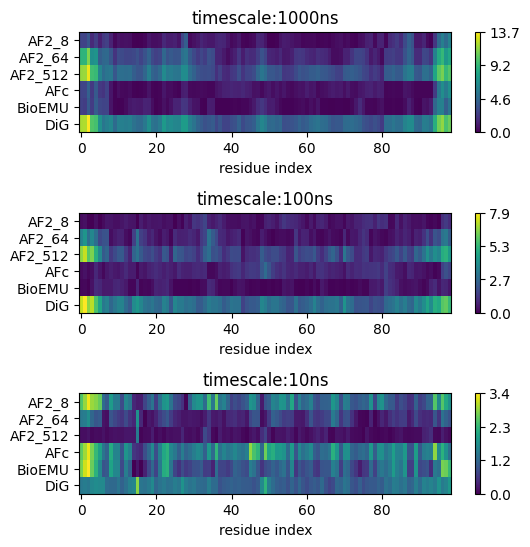

=========================== 2pc0 ===========================


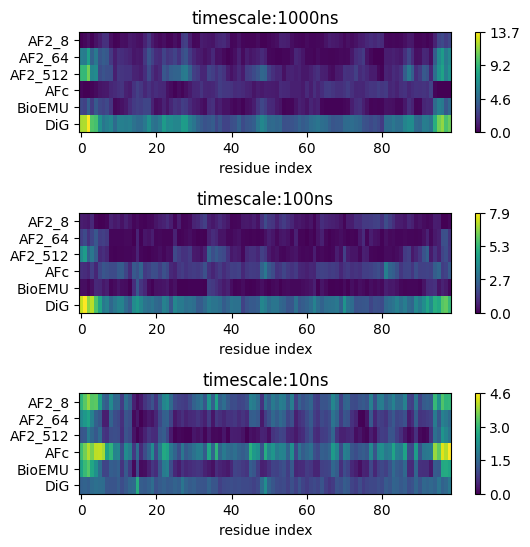

=========================== 1q9p ===========================


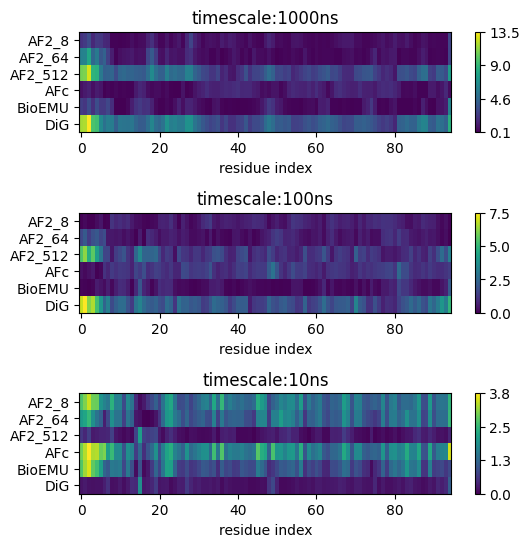

=========================== 1ebw ===========================


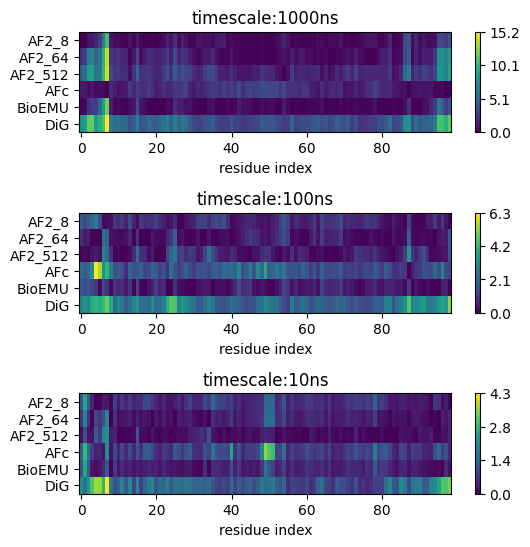

=========================== 4z4x ===========================


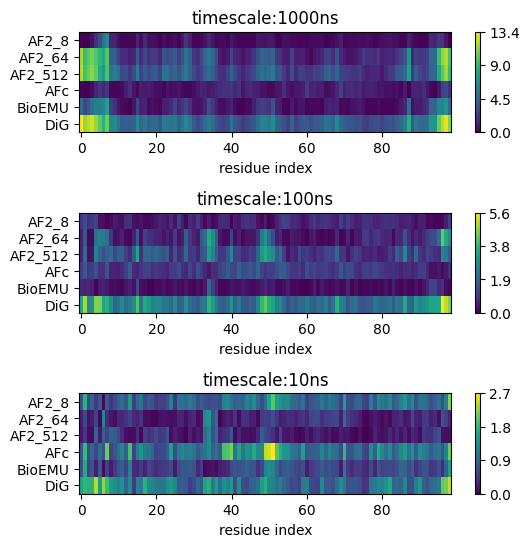

=========================== 6p9a ===========================


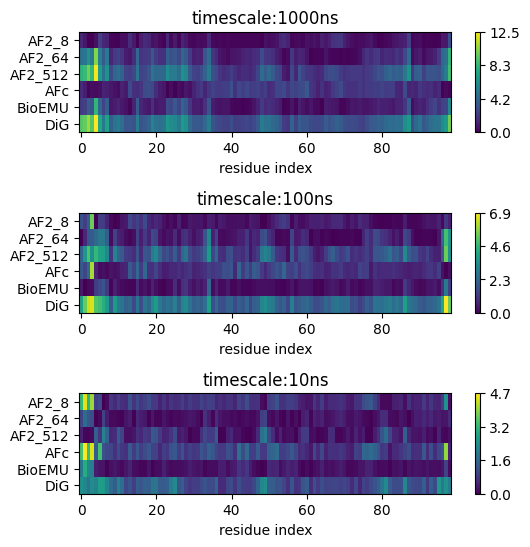

In [ ]:
methods_req=['AF2_8','AF2_64','AF2_512','AFc','BioEMU','DiG']
for ii,SYS in enumerate(sys_names):

    print(f'=========================== {SYS} ===========================')

    fig = plt.figure(figsize = (6, 6))
    for jj, timescale in enumerate(timescales):
        dummy=[]

        for kk, meth in enumerate(methods_req):
            dummy.append(DTW_distances[SYS][timescale]['dists'][meth])

        dummy=np.array(dummy)

        msa_counts=np.zeros(len(DTW_distances[SYS][timescale]['dists'].keys()))
        for rr in range(dummy.shape[1]):
            ind_min=np.where(dummy[:,rr]==dummy[:,rr].min())[0]
            msa_counts[ind_min]+=1
        msa_counts=msa_counts*100/dummy.shape[1]
        DTW_distances[SYS][timescale]['explained'] = {}
        for kk, meth in enumerate(methods_req):
            DTW_distances[SYS][timescale]['explained'][meth]=msa_counts[kk]

        plt.subplot(len(timescales),1,jj+1)
        plt.imshow(dummy, aspect = 'auto')
        ticks=np.linspace(dummy.min(),dummy.max(),4)
        cb=plt.colorbar(ticks=ticks)
        plt.yticks(ticks = np.arange(len(DTW_distances[SYS][timescale]['dists'].keys())), labels = [m for m in DTW_distances[SYS][timescale]['dists'].keys()])
        plt.xlabel('residue index')
        plt.title(f'timescale:{timescale}')
        cb.set_ticks(ticks=ticks,labels=[str(np.round(ti,1)) for ti in ticks])
#         cb.set_ticklabels(ticks,[str(np.round(ti,1)) for ti in ticks])
    plt.subplots_adjust(hspace=0.8)
    plt.show()
    plt.close()


=========================== 3ttp ===========================


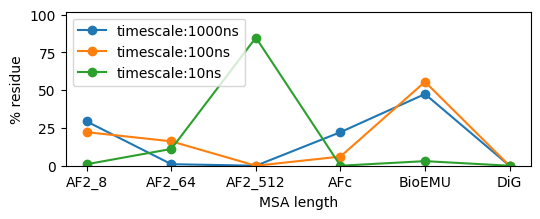

=========================== 2pc0 ===========================


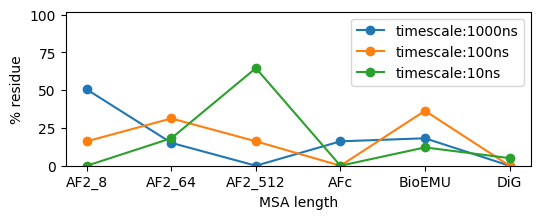

=========================== 1q9p ===========================


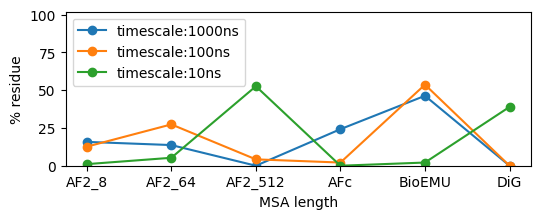

=========================== 1ebw ===========================


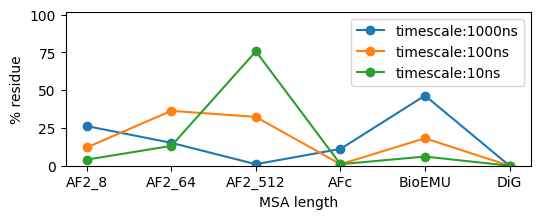

=========================== 4z4x ===========================


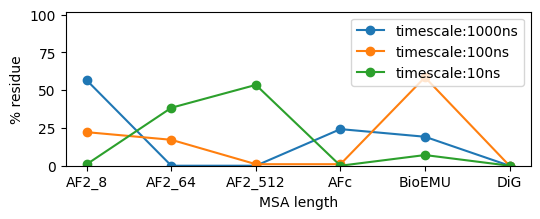

=========================== 6p9a ===========================


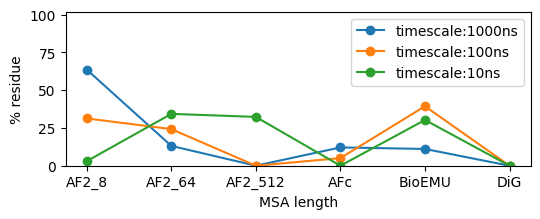

In [ ]:
for ii,SYS in enumerate(sys_names):

    print(f'=========================== {SYS} ===========================')

    fig = plt.figure(figsize = (6, 2))
    for jj, timescale in enumerate(timescales):
        dummy=[]

        for kk, meth in enumerate(DTW_distances[SYS][timescale]['explained'].keys()):
            dummy.append(DTW_distances[SYS][timescale]['explained'][meth])

        dummy=np.array(dummy)

        plt.plot(dummy, '-o',label=f'timescale:{timescale}')
        plt.xticks(ticks = np.arange(len(DTW_distances[SYS][timescale]['explained'].keys())), labels = [m for m in DTW_distances[SYS][timescale]['explained'].keys()])
    plt.legend()
    plt.xlabel('MSA length')
    plt.ylim([0,102])
    plt.ylabel('% residue');
    plt.show()
    plt.close()

In [ ]:
DTW_distances.keys(),DTW_distances['1ebw'].keys(),DTW_distances['1ebw']['1000ns'].keys(),DTW_distances['1ebw']['1000ns']['explained']

(dict_keys(['3ttp', '2pc0', '1q9p', '1ebw', '4z4x', '6p9a']),
 dict_keys(['1000ns', '100ns', '10ns']),
 dict_keys(['dists', 'explained']),
 {'AF2_8': np.float64(26.262626262626263),
  'AF2_64': np.float64(15.151515151515152),
  'AF2_512': np.float64(1.0101010101010102),
  'AFc': np.float64(11.11111111111111),
  'BioEMU': np.float64(46.464646464646464),
  'DiG': np.float64(0.0)})

# For Figures


In [ ]:
DTW_distances['1ebw']['1000ns']['explained']

{'AF2_8': np.float64(26.262626262626263),
 'AF2_64': np.float64(15.151515151515152),
 'AF2_512': np.float64(1.0101010101010102),
 'AFc': np.float64(11.11111111111111),
 'BioEMU': np.float64(46.464646464646464),
 'DiG': np.float64(0.0)}

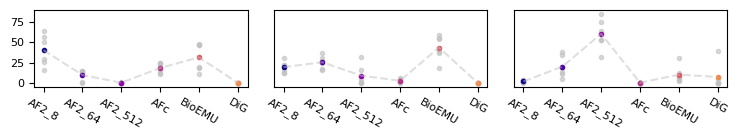

In [ ]:
sys_names=['1q9p','2pc0','3ttp','1ebw','4z4x','6p9a']
colors = plt.cm.plasma(np.linspace(0, 1, len(HA_tcf_calc['1ebw']['AF2']['msas'])+1))
plt.figure(figsize=(7.5,1.5))
for tt,times in enumerate(DTW_distances['1ebw'].keys()):
  plt.subplot(1,3,tt+1)
  explained_mean=np.zeros((len(sys_names),len(DTW_distances['1ebw']['1000ns']['explained'].keys())))
  for ss,sys in enumerate(sys_names):
    SYS=sys
    explained = DTW_distances[SYS][times]['explained']
    for mm,msa in enumerate(DTW_distances['1ebw']['1000ns']['explained'].keys()):
      explained_mean[ss,mm]=explained[msa]
      plt.plot(mm+2,explained[msa],'.',c='silver',alpha=0.6)
  explained_mean_vals=explained_mean.mean(0)
  for mm,msa in enumerate(DTW_distances['1ebw']['1000ns']['explained'].keys()):
    plt.plot(mm+2,explained_mean_vals[mm],'.',c=colors[mm])
  plt.plot(np.arange(6)+2,explained_mean_vals,'--',c='silver',alpha=0.5)

  plt.ylim([-5,90])
  if tt == 0:
    plt.yticks(np.arange(4)*25,fontsize=8)
  else:
    plt.yticks([])

  plt.xticks(np.arange(6)+2,labels=[str(msa) for msa in DTW_distances['1ebw']['1000ns']['explained'].keys()],fontsize=8, rotation = -30)
  plt.subplots_adjust(wspace=0.02)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/DTW_fig7.png',dpi=600);
plt.savefig('/content/DTW_fig7.png',dpi=600);
plt.show()

In [15]:
def integ(y,x):
    integ_v=np.trapz(y,x)
    # f=interp1d(x,y,kind='cubic')
    # xval=np.linspace(x[0]+0.01, x[-1]-0.01,num=129,endpoint=True)
    # integ_v=simps(f(xval),xval)
    #print('Integration value : '+str(integ_v)+'\n')
    return integ_v

In [16]:
sys_names=['3ttp', '2pc0', '1q9p', '1ebw','4z4x','6p9a']

In [17]:
avg_tau_md={}
cuts_md={}
for ss,sys in enumerate(sys_names):
  SYS=sys
  avg_tau_md[SYS]={}
  cuts_md[SYS]={}
  for jj, timescale in enumerate(DTW_distances['1ebw'].keys()):
    avg_tau_md[SYS][timescale]=np.zeros((nres_list[ss],1))
    cuts_md[SYS][timescale]=np.zeros((nres_list[ss],1),dtype=np.int32)
    for resi in range(0,nres_list[ss]):
      tcf_ref = HA_tcf_calc[SYS]['test'][timescale]['tcf'].T[1:]
      t_axis_ref = HA_tcf_calc[SYS]['test'][timescale]['tcf'].T[0]
      m = np.gradient(tcf_ref[resi])
      if np.where(m >= 0)[0].shape[0] == 0:
          cut = tcf_ref[resi].shape[0]
      else:
          cut = np.where(m >= 0)[0][0]
      avg_tau_md[SYS][timescale][resi,0] = integ(tcf_ref[resi,:cut],t_axis_ref[:cut])
      cuts_md[SYS][timescale][resi,0]=int(cut)


/tmp/ipython-input-15-3448413438.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_v=np.trapz(y,x)


In [18]:
sys_names=['3ttp', '2pc0', '1q9p', '1ebw','4z4x','6p9a']
barrier_type='scaled'

tau_avg_per_sys = {}
methods = [0, 2, 6, 'AFc', 'BioEMU', 'DiG']


for ii,sys in enumerate(sys_names):
  SYS=sys

  tau_avg_per_sys[SYS]={}
  for jj, timescale in enumerate(DTW_distances['1ebw'].keys()):
    tau_avg_per_sys[SYS][timescale] = {}

    t_axis = HA_tcf_calc[SYS]['AF2']['t_axis']

    tcf_list = []
    for i, meth in enumerate(methods):
      if type(meth) is int:
        tcf_list = tcf_list + [HA_tcf_calc[sys]['AF2'][barrier_type]['tcf'][meth]]
      else:
        tcf_list = tcf_list + HA_tcf_calc[sys][meth][barrier_type]['tcf']
    for mm,msa in enumerate(methods):
      tau_avg_per_sys[SYS][timescale][msa]= np.zeros((nres_list[ii],1))
      for resi in range(nres_list[ii]):
          cuts = cuts_md[SYS][timescale][resi,0]
          tau_avg_per_sys[SYS][timescale][msa][resi,0] = integ(tcf_list[mm].T[resi,:cuts],t_axis[:cuts])



/tmp/ipython-input-15-3448413438.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_v=np.trapz(y,x)


MSA = AFc, slope = 0.515804,intercept = 404.395,rvalue = 0.870521
MSA = BioEMU, slope = 0.967826,intercept = 378.267,rvalue = 0.980404
MSA = DiG, slope = 0.442955,intercept = 388.981,rvalue = 0.806307


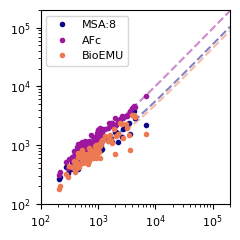

In [ ]:
from scipy import stats

SYS='1ebw'
msa_per_time=[0, 'AFc', 'BioEMU']
colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
colors_msa ={}
for mm,msa in enumerate(msa_per_time):
  colors_msa[msa]=colors[mm]

timescale ='1000ns'
xval=avg_tau_md[SYS][timescale]
yval1=tau_avg_per_sys[SYS][timescale][0]
yval2=tau_avg_per_sys[SYS][timescale]['AFc']
yval3=tau_avg_per_sys[SYS][timescale]['BioEMU']

xxx=np.linspace(1e3,1e6,10000)

res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
res2=stats.linregress(x=xval[:,0],y=yval2[:,0])
res3=stats.linregress(x=xval[:,0],y=yval3[:,0])
yyy1=res1.slope*xxx+res1.intercept
yyy2=res2.slope*xxx+res2.intercept
yyy3=res3.slope*xxx+res3.intercept

plt.figure(figsize=(2.5,2.5))
plt.plot(xxx,yyy1,'--',c=colors_msa[0],alpha=0.5)
plt.plot(xxx,yyy2,'--',c=colors_msa['AFc'],alpha=0.5)
plt.plot(xxx,yyy3,'--',c=colors_msa['BioEMU'],alpha=0.5)
print(f"MSA = AFc, slope = {res1.slope:2.6},intercept = {res1.intercept:2.6},rvalue = {res1.rvalue:2.6}")
print(f"MSA = BioEMU, slope = {res2.slope:2.6},intercept = {res2.intercept:2.6},rvalue = {res2.rvalue:2.6}")
print(f"MSA = DiG, slope = {res3.slope:2.6},intercept = {res3.intercept:2.6},rvalue = {res3.rvalue:2.6}")
plt.plot(xval,yval1,'.',c=colors_msa[0],label=f'MSA:{8}')
plt.plot(xval,yval2,'.',c=colors_msa['AFc'],label=f'AFc')
plt.plot(xval,yval3,'.',c=colors_msa['BioEMU'],label=f'BioEMU')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e2,2*1e5])
plt.xlim([1e2,2*1e5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/tau_avg_msa_compare_all_ML.png',dpi=600);
plt.savefig('/content/tau_avg_msa_compare_all_ML.png',dpi=600);
plt.show()

MSA = AFc, slope = 0.528752,intercept = 551.64,rvalue = 0.881406
MSA = BioEMU, slope = 0.611695,intercept = 237.634,rvalue = 0.934325
MSA = DiG, slope = -3.75967e-07,intercept = 2.50153,rvalue = -0.253663


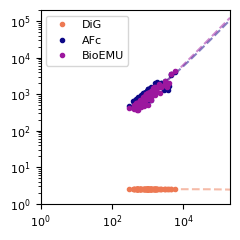

MSA = AFc, slope = 0.950683,intercept = 393.502,rvalue = 0.990852
MSA = BioEMU, slope = 0.626323,intercept = 110.84,rvalue = 0.947333
MSA = DiG, slope = 5.29823e-09,intercept = 2.5,rvalue = 0.52439


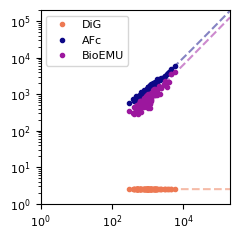

MSA = AFc, slope = 0.850633,intercept = 384.603,rvalue = 0.985915
MSA = BioEMU, slope = 0.735524,intercept = 109.711,rvalue = 0.951838
MSA = DiG, slope = 0.00192851,intercept = 106.688,rvalue = 0.0983869


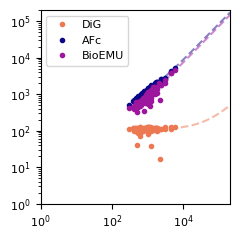

MSA = AFc, slope = 0.967826,intercept = 378.267,rvalue = 0.980404
MSA = BioEMU, slope = 0.442955,intercept = 388.981,rvalue = 0.806307
MSA = DiG, slope = 6.08395e-14,intercept = 2.5,rvalue = 0.24272


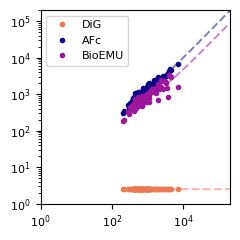

MSA = AFc, slope = 0.84196,intercept = 343.754,rvalue = 0.976635
MSA = BioEMU, slope = 0.515252,intercept = 141.888,rvalue = 0.940234
MSA = DiG, slope = 0.0,intercept = 2.5,rvalue = 0.0


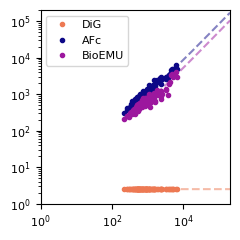

MSA = AFc, slope = 1.02876,intercept = 341.387,rvalue = 0.97546
MSA = BioEMU, slope = 0.451229,intercept = 155.384,rvalue = 0.885403
MSA = DiG, slope = 3.5967e-13,intercept = 2.5,rvalue = 0.591008


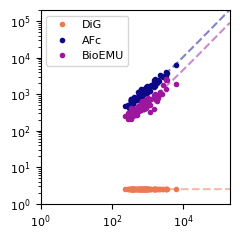

In [23]:
from scipy import stats

for SYS in sys_names:
  msa_per_time=['AFc', 'BioEMU', 'DiG']
  colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
  colors_msa ={}
  for mm,msa in enumerate(msa_per_time):
    colors_msa[msa]=colors[mm]

  timescale ='1000ns'
  xval=avg_tau_md[SYS][timescale]
  yval1=tau_avg_per_sys[SYS][timescale]['AFc']
  yval2=tau_avg_per_sys[SYS][timescale]['BioEMU']
  yval3=tau_avg_per_sys[SYS][timescale]['DiG']

  xxx=np.linspace(1e3,1e6,10000)

  res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
  res2=stats.linregress(x=xval[:,0],y=yval2[:,0])
  res3=stats.linregress(x=xval[:,0],y=yval3[:,0])
  yyy1=res1.slope*xxx+res1.intercept
  yyy2=res2.slope*xxx+res2.intercept
  yyy3=res3.slope*xxx+res3.intercept

  plt.figure(figsize=(2.5,2.5))
  plt.plot(xxx,yyy3,'--',c=colors_msa['DiG'],alpha=0.5)
  plt.plot(xxx,yyy1,'--',c=colors_msa['AFc'],alpha=0.5)
  plt.plot(xxx,yyy2,'--',c=colors_msa['BioEMU'],alpha=0.5)
  print(f"MSA = AFc, slope = {res1.slope:2.6},intercept = {res1.intercept:2.6},rvalue = {res1.rvalue:2.6}")
  print(f"MSA = BioEMU, slope = {res2.slope:2.6},intercept = {res2.intercept:2.6},rvalue = {res2.rvalue:2.6}")
  print(f"MSA = DiG, slope = {res3.slope:2.6},intercept = {res3.intercept:2.6},rvalue = {res3.rvalue:2.6}")
  plt.plot(xval,yval3,'.',c=colors_msa['DiG'],label=f'DiG')
  plt.plot(xval,yval1,'.',c=colors_msa['AFc'],label=f'AFc')
  plt.plot(xval,yval2,'.',c=colors_msa['BioEMU'],label=f'BioEMU')
  plt.xscale('log')
  plt.yscale('log')
  plt.ylim([1e0,2*1e5])
  plt.xlim([1e0,2*1e5])
  plt.xticks(fontsize=8)
  plt.yticks(fontsize=8)
  plt.legend(fontsize=8)

  plt.tight_layout()
  plt.savefig(f'/content/drive/MyDrive/AF2_dynamics/figures/tau_avg_msa_{SYS}_ML.png',dpi=600);
  plt.savefig(f'/content/tau_avg_msa_{SYS}_ML.png',dpi=600);
  plt.show()

MSA = AFc, slope = 0.844554,intercept = 98.8101,rvalue = 0.967046
MSA = BioEMU, slope = 0.84196,intercept = 343.754,rvalue = 0.976635
MSA = DiG, slope = 0.515252,intercept = 141.888,rvalue = 0.940234


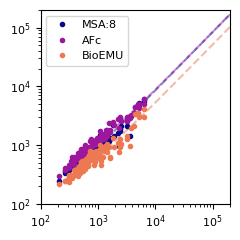

In [ ]:
from scipy import stats

SYS='4z4x'
msa_per_time=[0, 'AFc', 'BioEMU']
colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
colors_msa ={}
for mm,msa in enumerate(msa_per_time):
  colors_msa[msa]=colors[mm]

timescale ='1000ns'
xval=avg_tau_md[SYS][timescale]
yval1=tau_avg_per_sys[SYS][timescale][0]
yval2=tau_avg_per_sys[SYS][timescale]['AFc']
yval3=tau_avg_per_sys[SYS][timescale]['BioEMU']

xxx=np.linspace(1e3,1e6,10000)

res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
res2=stats.linregress(x=xval[:,0],y=yval2[:,0])
res3=stats.linregress(x=xval[:,0],y=yval3[:,0])
yyy1=res1.slope*xxx+res1.intercept
yyy2=res2.slope*xxx+res2.intercept
yyy3=res3.slope*xxx+res3.intercept

plt.figure(figsize=(2.5,2.5))
plt.plot(xxx,yyy1,'--',c=colors_msa[0],alpha=0.5)
plt.plot(xxx,yyy2,'--',c=colors_msa['AFc'],alpha=0.5)
plt.plot(xxx,yyy3,'--',c=colors_msa['BioEMU'],alpha=0.5)
print(f"MSA = AFc, slope = {res1.slope:2.6},intercept = {res1.intercept:2.6},rvalue = {res1.rvalue:2.6}")
print(f"MSA = BioEMU, slope = {res2.slope:2.6},intercept = {res2.intercept:2.6},rvalue = {res2.rvalue:2.6}")
print(f"MSA = DiG, slope = {res3.slope:2.6},intercept = {res3.intercept:2.6},rvalue = {res3.rvalue:2.6}")
plt.plot(xval,yval1,'.',c=colors_msa[0],label=f'MSA:{8}')
plt.plot(xval,yval2,'.',c=colors_msa['AFc'],label=f'AFc')
plt.plot(xval,yval3,'.',c=colors_msa['BioEMU'],label=f'BioEMU')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e2,2*1e5])
plt.xlim([1e2,2*1e5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/tau_avg_msa_compare_all_ML.png',dpi=600);
#plt.savefig('/content/tau_avg_msa_compare_all_ML.png',dpi=600);
plt.show()

MSA = AFc, slope = 0.843266,intercept = 186.002,rvalue = 0.951916
MSA = BioEMU, slope = 1.02876,intercept = 341.387,rvalue = 0.97546
MSA = DiG, slope = 0.451229,intercept = 155.384,rvalue = 0.885403


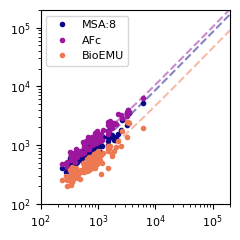

In [ ]:
from scipy import stats

SYS='6p9a'
msa_per_time=[0, 'AFc', 'BioEMU']
colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
colors_msa ={}
for mm,msa in enumerate(msa_per_time):
  colors_msa[msa]=colors[mm]

timescale ='1000ns'
xval=avg_tau_md[SYS][timescale]
yval1=tau_avg_per_sys[SYS][timescale][0]
yval2=tau_avg_per_sys[SYS][timescale]['AFc']
yval3=tau_avg_per_sys[SYS][timescale]['BioEMU']

xxx=np.linspace(1e3,1e6,10000)

res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
res2=stats.linregress(x=xval[:,0],y=yval2[:,0])
res3=stats.linregress(x=xval[:,0],y=yval3[:,0])
yyy1=res1.slope*xxx+res1.intercept
yyy2=res2.slope*xxx+res2.intercept
yyy3=res3.slope*xxx+res3.intercept

plt.figure(figsize=(2.5,2.5))
plt.plot(xxx,yyy1,'--',c=colors_msa[0],alpha=0.5)
plt.plot(xxx,yyy2,'--',c=colors_msa['AFc'],alpha=0.5)
plt.plot(xxx,yyy3,'--',c=colors_msa['BioEMU'],alpha=0.5)
print(f"MSA = AFc, slope = {res1.slope:2.6},intercept = {res1.intercept:2.6},rvalue = {res1.rvalue:2.6}")
print(f"MSA = BioEMU, slope = {res2.slope:2.6},intercept = {res2.intercept:2.6},rvalue = {res2.rvalue:2.6}")
print(f"MSA = DiG, slope = {res3.slope:2.6},intercept = {res3.intercept:2.6},rvalue = {res3.rvalue:2.6}")
plt.plot(xval,yval1,'.',c=colors_msa[0],label=f'MSA:{8}')
plt.plot(xval,yval2,'.',c=colors_msa['AFc'],label=f'AFc')
plt.plot(xval,yval3,'.',c=colors_msa['BioEMU'],label=f'BioEMU')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e2,2*1e5])
plt.xlim([1e2,2*1e5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/tau_avg_msa_compare_all_ML.png',dpi=600);
#plt.savefig('/content/tau_avg_msa_compare_all_ML.png',dpi=600);
plt.show()

MSA = AFc, slope = 0.558172,intercept = 369.893,rvalue = 0.900696
MSA = BioEMU, slope = 0.528752,intercept = 551.64,rvalue = 0.881406
MSA = DiG, slope = 0.611695,intercept = 237.634,rvalue = 0.934325


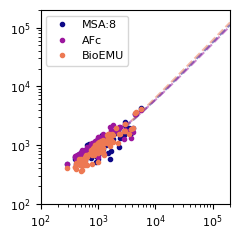

In [ ]:
from scipy import stats

SYS='3ttp'
msa_per_time=[0, 'AFc', 'BioEMU']
colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
colors_msa ={}
for mm,msa in enumerate(msa_per_time):
  colors_msa[msa]=colors[mm]

timescale ='1000ns'
xval=avg_tau_md[SYS][timescale]
yval1=tau_avg_per_sys[SYS][timescale][0]
yval2=tau_avg_per_sys[SYS][timescale]['AFc']
yval3=tau_avg_per_sys[SYS][timescale]['BioEMU']

xxx=np.linspace(1e3,1e6,10000)

res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
res2=stats.linregress(x=xval[:,0],y=yval2[:,0])
res3=stats.linregress(x=xval[:,0],y=yval3[:,0])
yyy1=res1.slope*xxx+res1.intercept
yyy2=res2.slope*xxx+res2.intercept
yyy3=res3.slope*xxx+res3.intercept

plt.figure(figsize=(2.5,2.5))
plt.plot(xxx,yyy1,'--',c=colors_msa[0],alpha=0.5)
plt.plot(xxx,yyy2,'--',c=colors_msa['AFc'],alpha=0.5)
plt.plot(xxx,yyy3,'--',c=colors_msa['BioEMU'],alpha=0.5)
print(f"MSA = AFc, slope = {res1.slope:2.6},intercept = {res1.intercept:2.6},rvalue = {res1.rvalue:2.6}")
print(f"MSA = BioEMU, slope = {res2.slope:2.6},intercept = {res2.intercept:2.6},rvalue = {res2.rvalue:2.6}")
print(f"MSA = DiG, slope = {res3.slope:2.6},intercept = {res3.intercept:2.6},rvalue = {res3.rvalue:2.6}")
plt.plot(xval,yval1,'.',c=colors_msa[0],label=f'MSA:{8}')
plt.plot(xval,yval2,'.',c=colors_msa['AFc'],label=f'AFc')
plt.plot(xval,yval3,'.',c=colors_msa['BioEMU'],label=f'BioEMU')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e2,2*1e5])
plt.xlim([1e2,2*1e5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/tau_avg_msa_compare_all_ML.png',dpi=600);
#plt.savefig('/content/tau_avg_msa_compare_all_ML.png',dpi=600);
plt.show()

MSA = AFc, slope = 0.791618,intercept = 245.765,rvalue = 0.963433
MSA = BioEMU, slope = 0.950683,intercept = 393.502,rvalue = 0.990852
MSA = DiG, slope = 0.626323,intercept = 110.84,rvalue = 0.947333


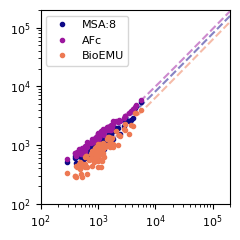

In [ ]:
from scipy import stats

SYS='2pc0'
msa_per_time=[0, 'AFc', 'BioEMU']
colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
colors_msa ={}
for mm,msa in enumerate(msa_per_time):
  colors_msa[msa]=colors[mm]

timescale ='1000ns'
xval=avg_tau_md[SYS][timescale]
yval1=tau_avg_per_sys[SYS][timescale][0]
yval2=tau_avg_per_sys[SYS][timescale]['AFc']
yval3=tau_avg_per_sys[SYS][timescale]['BioEMU']

xxx=np.linspace(1e3,1e6,10000)

res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
res2=stats.linregress(x=xval[:,0],y=yval2[:,0])
res3=stats.linregress(x=xval[:,0],y=yval3[:,0])
yyy1=res1.slope*xxx+res1.intercept
yyy2=res2.slope*xxx+res2.intercept
yyy3=res3.slope*xxx+res3.intercept

plt.figure(figsize=(2.5,2.5))
plt.plot(xxx,yyy1,'--',c=colors_msa[0],alpha=0.5)
plt.plot(xxx,yyy2,'--',c=colors_msa['AFc'],alpha=0.5)
plt.plot(xxx,yyy3,'--',c=colors_msa['BioEMU'],alpha=0.5)
print(f"MSA = AFc, slope = {res1.slope:2.6},intercept = {res1.intercept:2.6},rvalue = {res1.rvalue:2.6}")
print(f"MSA = BioEMU, slope = {res2.slope:2.6},intercept = {res2.intercept:2.6},rvalue = {res2.rvalue:2.6}")
print(f"MSA = DiG, slope = {res3.slope:2.6},intercept = {res3.intercept:2.6},rvalue = {res3.rvalue:2.6}")
plt.plot(xval,yval1,'.',c=colors_msa[0],label=f'MSA:{8}')
plt.plot(xval,yval2,'.',c=colors_msa['AFc'],label=f'AFc')
plt.plot(xval,yval3,'.',c=colors_msa['BioEMU'],label=f'BioEMU')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e2,2*1e5])
plt.xlim([1e2,2*1e5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/tau_avg_msa_compare_all_ML.png',dpi=600);
#plt.savefig('/content/tau_avg_msa_compare_all_ML.png',dpi=600);
plt.show()

MSA = AFc, slope = 0.698376,intercept = 320.216,rvalue = 0.972641
MSA = BioEMU, slope = 0.850633,intercept = 384.603,rvalue = 0.985915
MSA = DiG, slope = 0.735524,intercept = 109.711,rvalue = 0.951838


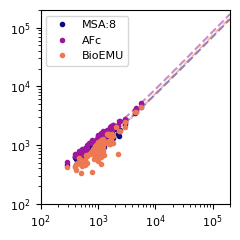

In [ ]:
from scipy import stats

SYS='1q9p'
msa_per_time=[0, 'AFc', 'BioEMU']
colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
colors_msa ={}
for mm,msa in enumerate(msa_per_time):
  colors_msa[msa]=colors[mm]

timescale ='1000ns'
xval=avg_tau_md[SYS][timescale]
yval1=tau_avg_per_sys[SYS][timescale][0]
yval2=tau_avg_per_sys[SYS][timescale]['AFc']
yval3=tau_avg_per_sys[SYS][timescale]['BioEMU']

xxx=np.linspace(1e3,1e6,10000)

res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
res2=stats.linregress(x=xval[:,0],y=yval2[:,0])
res3=stats.linregress(x=xval[:,0],y=yval3[:,0])
yyy1=res1.slope*xxx+res1.intercept
yyy2=res2.slope*xxx+res2.intercept
yyy3=res3.slope*xxx+res3.intercept

plt.figure(figsize=(2.5,2.5))
plt.plot(xxx,yyy1,'--',c=colors_msa[0],alpha=0.5)
plt.plot(xxx,yyy2,'--',c=colors_msa['AFc'],alpha=0.5)
plt.plot(xxx,yyy3,'--',c=colors_msa['BioEMU'],alpha=0.5)
print(f"MSA = AFc, slope = {res1.slope:2.6},intercept = {res1.intercept:2.6},rvalue = {res1.rvalue:2.6}")
print(f"MSA = BioEMU, slope = {res2.slope:2.6},intercept = {res2.intercept:2.6},rvalue = {res2.rvalue:2.6}")
print(f"MSA = DiG, slope = {res3.slope:2.6},intercept = {res3.intercept:2.6},rvalue = {res3.rvalue:2.6}")
plt.plot(xval,yval1,'.',c=colors_msa[0],label=f'MSA:{8}')
plt.plot(xval,yval2,'.',c=colors_msa['AFc'],label=f'AFc')
plt.plot(xval,yval3,'.',c=colors_msa['BioEMU'],label=f'BioEMU')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e2,2*1e5])
plt.xlim([1e2,2*1e5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/tau_avg_msa_compare_all_ML.png',dpi=600);
#plt.savefig('/content/tau_avg_msa_compare_all_ML.png',dpi=600);
plt.show()

MSA = AFc, slope = 0.850633,intercept = 384.603,rvalue = 0.985915
MSA = BioEMU, slope = 0.735524,intercept = 109.711,rvalue = 0.951838
MSA = DiG, slope = 0.00192851,intercept = 106.688,rvalue = 0.0983869


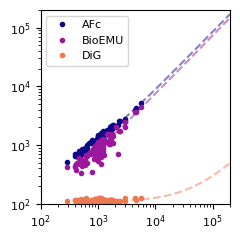

In [ ]:
from scipy import stats

SYS='1q9p'
msa_per_time=['AFc', 'BioEMU', 'DiG']
colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
colors_msa ={}
for mm,msa in enumerate(msa_per_time):
  colors_msa[msa]=colors[mm]

timescale ='1000ns'
xval=avg_tau_md[SYS][timescale]
yval1=tau_avg_per_sys[SYS][timescale]['AFc']
yval2=tau_avg_per_sys[SYS][timescale]['BioEMU']
yval3=tau_avg_per_sys[SYS][timescale]['DiG']

xxx=np.linspace(1e3,1e6,10000)

res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
res2=stats.linregress(x=xval[:,0],y=yval2[:,0])
res3=stats.linregress(x=xval[:,0],y=yval3[:,0])
yyy1=res1.slope*xxx+res1.intercept
yyy2=res2.slope*xxx+res2.intercept
yyy3=res3.slope*xxx+res3.intercept

plt.figure(figsize=(2.5,2.5))
plt.plot(xxx,yyy1,'--',c=colors_msa['AFc'],alpha=0.5)
plt.plot(xxx,yyy2,'--',c=colors_msa['BioEMU'],alpha=0.5)
plt.plot(xxx,yyy3,'--',c=colors_msa['DiG'],alpha=0.5)
print(f"MSA = AFc, slope = {res1.slope:2.6},intercept = {res1.intercept:2.6},rvalue = {res1.rvalue:2.6}")
print(f"MSA = BioEMU, slope = {res2.slope:2.6},intercept = {res2.intercept:2.6},rvalue = {res2.rvalue:2.6}")
print(f"MSA = DiG, slope = {res3.slope:2.6},intercept = {res3.intercept:2.6},rvalue = {res3.rvalue:2.6}")
plt.plot(xval,yval1,'.',c=colors_msa['AFc'],label=f'AFc')
plt.plot(xval,yval2,'.',c=colors_msa['BioEMU'],label=f'BioEMU')
plt.plot(xval,yval3,'.',c=colors_msa['DiG'],label=f'DiG')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e2,2*1e5])
plt.xlim([1e2,2*1e5])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/tau_avg_msa_compare_all_ML_w_DiG.png',dpi=600);
plt.savefig('/content/tau_avg_msa_compare_all_ML_w_DiG.png',dpi=600);
plt.show()

In [ ]:
from scipy import stats

msa_per_time=['AFc', 'BioEMU', 'DiG']
colors = plt.cm.plasma(np.linspace(0, 1, len(msa_per_time) + 1))
colors_msa ={}
for mm,msa in enumerate(msa_per_time):
  colors_msa[msa]=colors[mm]


pearson_correl={}
slopes={}

#sys_names=['1q9p','2pc0','3ttp','1ebw','4z4x','6p9a']
barrier_type='scaled'

for sys in sys_names:
  SYS=sys
  pearson_correl[SYS]={}
  slopes[SYS]={}
  for jj, timescale in enumerate(DTW_distances['1ebw'].keys()):
    pearson_correl[SYS][timescale]={}
    slopes[SYS][timescale]={}

    xval=avg_tau_md[SYS][timescale]
    for mm, msa in enumerate(methods):
      if msa in ['AFc', 'BioEMU', 'DiG']:
        yval1=tau_avg_per_sys[SYS][timescale][msa]
        res1=stats.linregress(x=xval[:,0],y=yval1[:,0])
        pearson_correl[SYS][timescale][msa]=res1.rvalue
        slopes[SYS][timescale][msa]=res1.slope



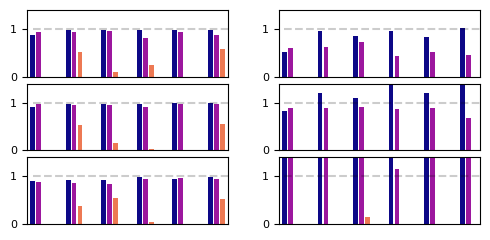

In [ ]:
plt.figure(figsize=(5,2.5))
for jj, timescale in enumerate(DTW_distances['1ebw'].keys()):
  dummy=[]
  plt.subplot(3,2,jj*2+1)
  for ss,sys in enumerate(sys_names):
    xx=ss*len(sys_names)
    SYS=sys
    for msa in ['AFc', 'BioEMU', 'DiG']:
      plt.bar(xx,pearson_correl[SYS][timescale][msa],color=colors_msa[msa])
      xx+=1
  plt.plot([0,xx],[1,1],'--k',alpha=0.2)
  plt.ylim([0,1.4])
  plt.xlim([-1,xx])
  plt.yticks(fontsize=8)
  plt.xticks([])

  plt.subplot(3,2,jj*2+2)
  for ss,sys in enumerate(sys_names):
    xx=ss*len(sys_names)
    SYS=sys
    for msa in ['AFc', 'BioEMU', 'DiG']:
      plt.bar(xx,slopes[SYS][timescale][msa],color=colors_msa[msa])
      xx+=1
  plt.plot([0,xx],[1,1],'--k',alpha=0.2)
  plt.xlim([-1,xx])
  plt.ylim([0,1.4])
  plt.yticks(fontsize=8)
  plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(hspace=0.1,wspace=0.25)

plt.savefig('/content/drive/MyDrive/AF2_dynamics/figures/pearson_correl_slopes_all_ML.png',dpi=600);
plt.savefig('/content/pearson_correl_slopes_all_ML.png',dpi=600);
plt.show()
